# Research on verifying people's age


* **The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws <u><i>'by making sure they do not sell alcohol to people underage'</i></u>.**



* You are asked to conduct that evaluation, so as you set to work, keep the following in mind:
  * The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
  * Computer vision methods can be used to determine age of a person from a photo
  * <b><font color='red'>The task then is to build and evaluate a model for verifying people's age</font></b>


**Data description & technical details** 

* The data was downloaded from **<a href="https://chalearnlap.cvc.uab.cat/dataset/26/description/">ChaLearn Looking at People</a>.** 
* It is stored in the /datasets/faces/ folder.
* **To help, you have** 
  - **<i>a folder with all the photos (/final_files)</i>** 
  - **<i>csv file labels.csv with two columns: file_name and real_age.</i>**
* As the number of image files is rather high, it is advisable to avoid reading them all at once, which would be resource consuming, and to read them sequentially with the ImageDataGenerator generator.

###### <font color='red'><u>Initialization - Import relevant libraries</u></font>

In [1]:
# enabling GPU support for future training
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.sched_setaffinity(0, range(5,10))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.simplefilter ('ignore')
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Conv2D,AvgPool2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there we can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`


In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


## EDA

In [6]:
labels.sample(10)

,file_name,real_age
2017,002017.jpg,32
2487,002487.jpg,6
6653,006658.jpg,32
6290,006294.jpg,27
4346,004346.jpg,23
6839,006848.jpg,8
6107,006110.jpg,34
2331,002331.jpg,58
3035,003035.jpg,23
2478,002478.jpg,21


In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [8]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

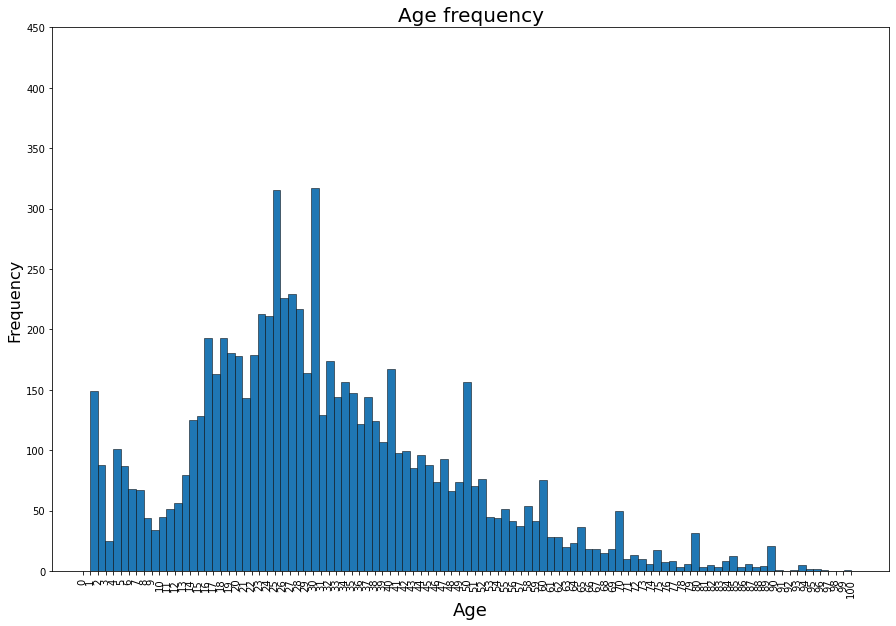

In [9]:
plt.figure(figsize=(15,10),edgecolor='blue')
plt.hist(labels['real_age'],bins=100,edgecolor='black', linewidth=0.5)
plt.xticks(np.arange(0, 101, 1),rotation='vertical')
plt.yticks(np.arange(0, 500, 50))
plt.title('Age frequency', fontsize=20)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

* only for convenience purpose  the range of four was chosen to split the data into groups

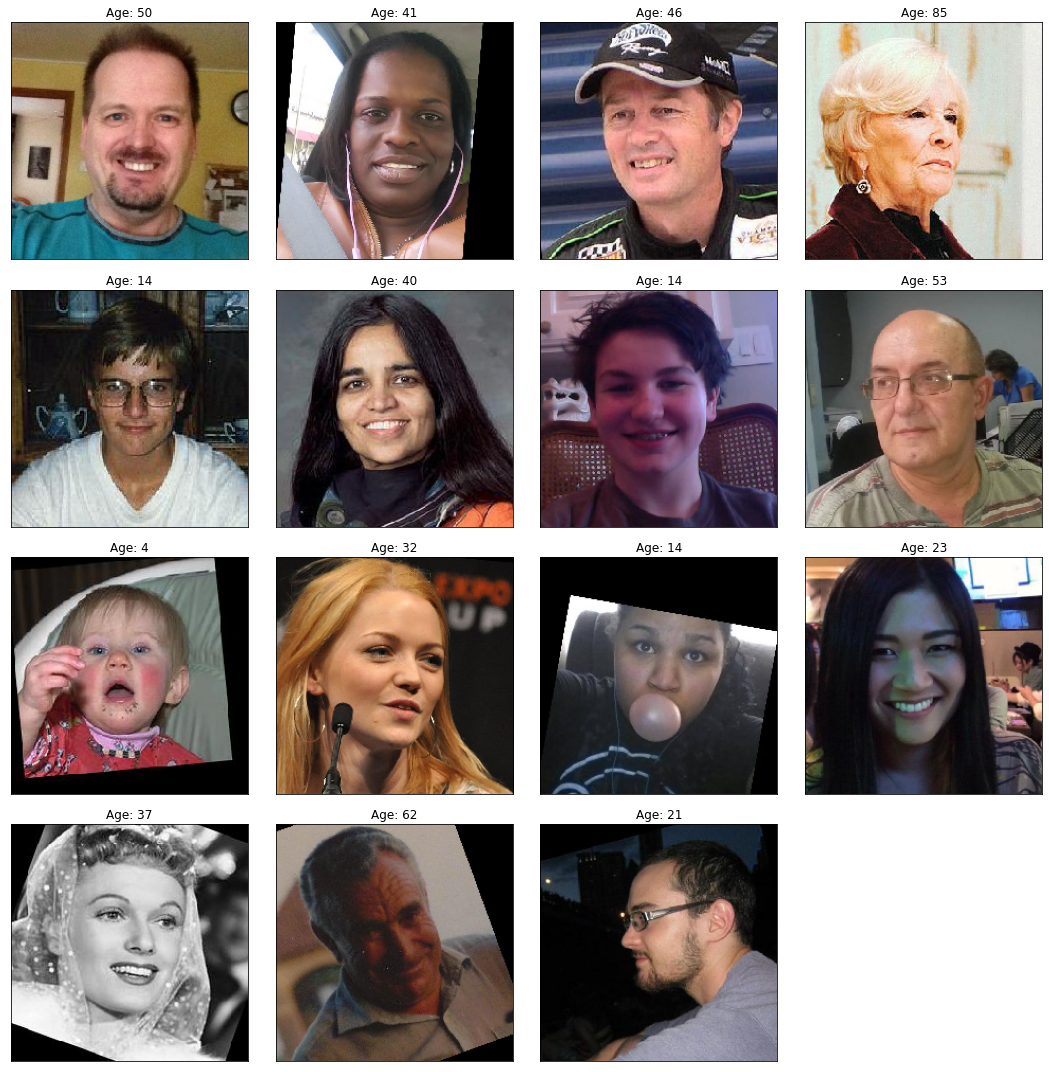

In [10]:
features, target = next(train_gen_flow)

# display 15 images
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    title_is = 'Age: ' + str(target[i])
    plt.title(title_is, fontsize=12)
    plt.tight_layout()

### Findings

* The average age is 31 
* The largest population is the people in age range [16,32]
  * Photos of people age 30 has the highest frequency 
* The smallest population is the people in age range [80,100]
  * Photos of people age 96+ has the lowest frequency 
* From the sample above we see there are photos of people of various ages
  * teens
  * children
  * adults
  * elders 
* And that we saw also from the labels descriptive data 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,shear_range=0.2,horizontal_flip=True)
    """
    It loads the train part of dataset from path
    """
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)    


    return train_gen_flow

In [13]:
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=(150, 150, 3), weights='imagenet',include_top=False)
    optimizer = Adam(lr=0.001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

* Running the model from the previous lesson we got:
  * MAE = 7.44 on the test set, which is fantastic value also below the threshold that was required
* In some epochs the values exceed the threshold (2-4,6-7), but it improved at the last epochs 
* Running the model didn't take so much time and that is due to the layers and neurons reductions on the create model method
  * less layers mean less complex model and less time consumption 

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [16]:
# prepare a script to run on the GPU platform

init_str = '#run model on gpu'
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


import inspect

with open('age_detection_resnet50.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')


### Output

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/20
2022-04-16 23:51:14.520905: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-04-16 23:51:17.804002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 144s - loss: 222.9378 - mean_absolute_error: 11.3058 - val_loss: 560.0639 - val_mean_absolute_error: 18.6402
Epoch 2/20
178/178 - 60s - loss: 149.6284 - mean_absolute_error: 9.2956 - val_loss: 285.9801 - val_mean_absolute_error: 13.3881
Epoch 3/20
178/178 - 60s - loss: 125.0420 - mean_absolute_error: 8.4588 - val_loss: 315.8442 - val_mean_absolute_error: 13.1723
Epoch 4/20
178/178 - 60s - loss: 104.3232 - mean_absolute_error: 7.8635 - val_loss: 256.6219 - val_mean_absolute_error: 12.0892
Epoch 5/20
178/178 - 60s - loss: 93.9108 - mean_absolute_error: 7.4287 - val_loss: 128.1965 - val_mean_absolute_error: 8.6824
Epoch 6/20
178/178 - 60s - loss: 85.2199 - mean_absolute_error: 7.0761 - val_loss: 299.7235 - val_mean_absolute_error: 12.9757
Epoch 7/20
178/178 - 60s - loss: 72.0844 - mean_absolute_error: 6.5291 - val_loss: 234.6571 - val_mean_absolute_error: 11.2141
Epoch 8/20
178/178 - 60s - loss: 63.4105 - mean_absolute_error: 6.0870 - val_loss: 120.2402 - val_mean_absolute_error: 8.2411
Epoch 9/20
178/178 - 60s - loss: 51.8074 - mean_absolute_error: 5.5444 - val_loss: 103.4696 - val_mean_absolute_error: 7.7433
Epoch 10/20
178/178 - 60s - loss: 48.8695 - mean_absolute_error: 5.4006 - val_loss: 127.8749 - val_mean_absolute_error: 8.4495
Epoch 11/20
178/178 - 60s - loss: 37.4905 - mean_absolute_error: 4.7728 - val_loss: 109.9604 - val_mean_absolute_error: 7.8251
Epoch 12/20
178/178 - 60s - loss: 34.6648 - mean_absolute_error: 4.5299 - val_loss: 131.1633 - val_mean_absolute_error: 8.6457
Epoch 13/20
178/178 - 60s - loss: 29.1985 - mean_absolute_error: 4.1623 - val_loss: 93.7714 - val_mean_absolute_error: 7.2214
Epoch 14/20
178/178 - 60s - loss: 24.2412 - mean_absolute_error: 3.8139 - val_loss: 104.5258 - val_mean_absolute_error: 7.5733
Epoch 15/20
178/178 - 60s - loss: 22.6154 - mean_absolute_error: 3.6616 - val_loss: 89.6416 - val_mean_absolute_error: 7.1690
Epoch 16/20
178/178 - 60s - loss: 21.1203 - mean_absolute_error: 3.5617 - val_loss: 98.3135 - val_mean_absolute_error: 7.3881
Epoch 17/20
178/178 - 60s - loss: 17.2888 - mean_absolute_error: 3.2257 - val_loss: 115.8098 - val_mean_absolute_error: 8.1718
Epoch 18/20
178/178 - 60s - loss: 15.6369 - mean_absolute_error: 3.0204 - val_loss: 95.4899 - val_mean_absolute_error: 7.3751
Epoch 19/20
178/178 - 60s - loss: 15.5332 - mean_absolute_error: 2.9987 - val_loss: 109.5414 - val_mean_absolute_error: 8.1571
Epoch 20/20
178/178 - 60s - loss: 13.9547 - mean_absolute_error: 2.8809 - val_loss: 101.0779 - val_mean_absolute_error: 7.4771

60/60 - 9s - loss: 101.0779 - mean_absolute_error: 7.4771
Test MAE: 7.4771



#run model on gpu

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,shear_range=0.2,horizontal_flip=True)
    """
    It loads the train part of dataset from path
    """
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)    
    # place your code here

    return train_gen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    backbone = ResNet50(input_shape=(150, 150, 3), weights='imagenet',include_top=False)
    optimizer = Adam(lr=0.001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Conclusions

* In the first stage, data was loaded and observed:
  * 7591 entries with two attributes: file name and real age
  * data without null values 
  * For the photos folder a train model was reloaded
  
  
* In the second stage, some EDA was performed 
  * The average age is 31 
  * Photos of people age 30 has the highest frequency 
  * Photos of people age 96+ has the lowest frequency 
  * From the sample of the photos we saw there are photos of people of various ages
    * teens
    * children
    * adults
    * elders 
  * And that we saw also from the labels descriptive data  
  
  
* In the third stage, building model for detecting/predicting the age:
  * Using ResNet50 with few layers and with combination of Adam optimizer with a single neuron for the Dense layer
  * Running the model from the previous lesson we got:
     * MAE = 7.44 on the test set, which is fantastic value also below the threshold that was required
  * In some epochs the values exceed the threshold (2-4,6-7), but it improved at the last epochs 
  * Running the model didn't take so much time and that is due to the layers reductions on the create model method
     * less layers mean less complex model and less time consumption ( - less typing also :) - ) 
     
* In the fourth stage, running the model on the GPU platform and copying the result to a separate text/markdown cell 